In [1]:
# read in shapefile
import geopandas as gpd
import pandas as pd
import numpy as np

## Writing intersection function
Using: https://gis.stackexchange.com/questions/387773/count-overlapping-features-using-geopandas

In [2]:
import pandas as pd
import matplotlib as plt
import geopandas as gpd
from shapely import wkt
data = {'name':  ['polygon A', 'polygon B', 'polygon C'],
        'id': [1, 2, 3],
         'geom': ['MULTIPOLYGON (((36.00000 11.00000, 36.00000 12.00000, 37.00000 12.00000, 37.00000 11.00000, 36.00000 11.00000)))', 'MULTIPOLYGON (((36.50000 11.50000, 37.50000 11.50000, 37.50000 11.00000, 36.50000 11.00000, 36.50000 11.50000)))', 'MULTIPOLYGON (((36.61799 10.80580, 36.61570 11.19321, 36.86327 11.29637, 37.34925 10.91813, 37.00540 10.71182, 36.61799 10.80580)))']
        }

df = pd.DataFrame (data, columns = ['name','id','geom'])
df['geom'] = df['geom'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geom')
gdf

,name,id,geom
0,polygon A,1,"MULTIPOLYGON (((36.00000 11.00000, 36.00000 12..."
1,polygon B,2,"MULTIPOLYGON (((36.50000 11.50000, 37.50000 11..."
2,polygon C,3,"MULTIPOLYGON (((36.61799 10.80580, 36.61570 11..."


<Axes: >

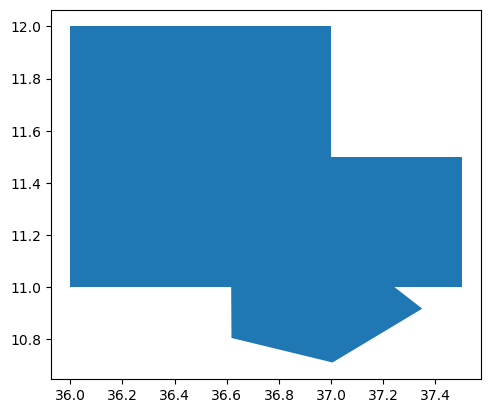

In [32]:
gdf.plot()

<Axes: >

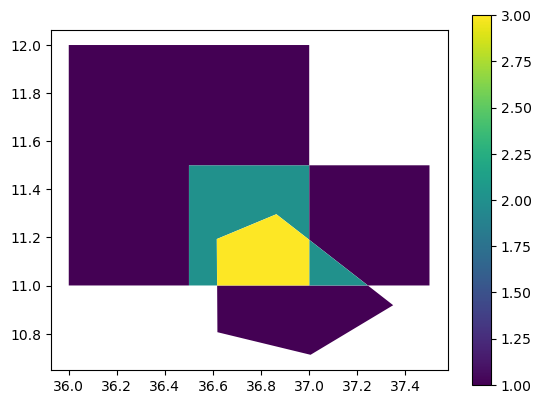

In [3]:
SMALL_NUMBER = 0.0001
def count_overlap(gdf):
    import shapely
    bounds = gdf.geometry.convex_hull.exterior.buffer(SMALL_NUMBER).unary_union
    new_polys = list(shapely.ops.polygonize(bounds))
    # Removing the full merged polygons (first is always index 0, 
    # subsequent will be the first of their own 'bunches' identified as disjoint from other 'bunches')
    bad_poly_idx = [0]
    while new_polys[max(bad_poly_idx)].disjoint(new_polys[-1]):
        for idx in range(max(bad_poly_idx), len(new_polys)):
            if new_polys[max(bad_poly_idx)].disjoint(new_polys[idx]):
                bad_poly_idx += [idx]
                break
    new_polys = [new_polys[i].buffer(-SMALL_NUMBER) for i in range(len(new_polys)) if i not in bad_poly_idx]
    # count layers
    new_gdf = gpd.GeoDataFrame(geometry=new_polys)
    new_gdf['layers'] = sum([new_gdf.geometry.intersects(poly) for poly in gdf.geometry.buffer(SMALL_NUMBER).values])
    new_gdf['piece'] = new_gdf.index
    return new_gdf

count_overlap(gdf).plot('layers', legend=True)

# Applying to species data

In [4]:
# read in shapefile
gdf = gpd.read_file('/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/reeftruth/data/IUCN_species_data/data_1.shp')

In [5]:
gdf.head()

,ASSESSMENT,ID_NO,SCI_NAME,PRESENCE,ORIGIN,SEASONAL,COMPILER,YRCOMPILED,CITATION,LEGEND,SUBSPECIES,SUBPOP,DIST_COMM,ISLAND,TAX_COMM,geometry
0,3484188.0,132900.0,Lobophyllia radians,1,1,1,IUCN,2009,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,"MULTIPOLYGON (((94.68272 16.29783, 94.66775 16..."
1,3488908.0,132910.0,Acropora divaricata,1,1,1,IUCN,2009,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,"MULTIPOLYGON (((94.68272 16.29783, 94.66775 16..."
2,3520070.0,132979.0,Favites complanata,1,1,1,IUCN,2009,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,"MULTIPOLYGON (((94.68272 16.29783, 94.66775 16..."
3,3524260.0,132987.0,Echinopora gemmacea,1,1,1,IUCN,2009,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,"MULTIPOLYGON (((94.68272 16.29783, 94.66775 16..."
4,3545567.0,133015.0,Montipora millepora,1,1,1,IUCN,2009,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,"MULTIPOLYGON (((99.07516 7.94581, 99.07794 7.9..."


In [7]:
SMALL_NUMBER = 0.1

out = count_overlap(gdf.iloc[0:2])

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_44305/3479064888.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bounds = gdf.geometry.convex_hull.exterior.buffer(SMALL_NUMBER).unary_union
/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_44305/3479064888.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gdf['layers'] = sum([new_gdf.geometry.intersects(poly) for poly in gdf.geometry.buffer(SMALL_NUMBER).values])


<Axes: >

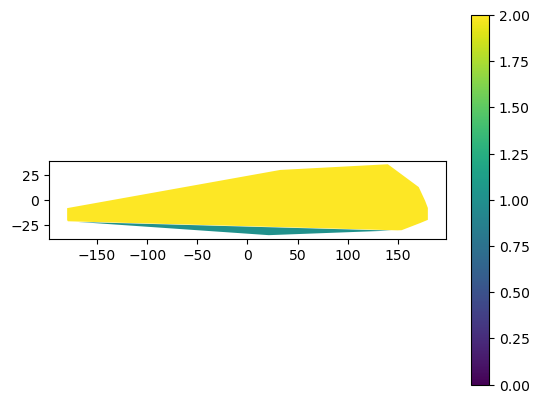

In [8]:
out.plot('layers', legend=True)

In [26]:
import shapely
def count_overlapping_features(in_gdf):
    # Get the name of the column containing the geometries
    geom_col = in_gdf.geometry.name
    
    # Setting up a single piece that will be split later
    input_parts = [in_gdf.unary_union.buffer(0)]
    
    # Finding all the "cutting" boundaries. Note: if the input GDF has 
    # MultiPolygons, it will treat each of the geometry's parts as individual
    # pieces.
    cutting_boundaries = []
    for i, row in in_gdf.iterrows():
        this_row_geom = row[geom_col]
        this_row_boundary = this_row_geom.boundary
        if this_row_boundary.type[:len('multi')].lower() == 'multi':
            cutting_boundaries = cutting_boundaries + list(this_row_boundary.geoms)
        else:
            cutting_boundaries.append(this_row_boundary)
    
    
    # Split the big input geometry using each and every cutting boundary
    for boundary in cutting_boundaries:
        splitting_results = []
        for j,part in enumerate(input_parts):
            new_parts = list(shapely.ops.split(part, boundary).geoms)
            splitting_results = splitting_results + new_parts
        input_parts = splitting_results
    
    # After generating all of the split pieces, create a new GeoDataFrame
    new_gdf = gpd.GeoDataFrame({'id':range(len(splitting_results)),
                                geom_col:splitting_results,
                                },
                               crs=in_gdf.crs,
                               geometry=geom_col)
    
    # Find the new centroids.
    new_gdf['geom_centroid'] = new_gdf.centroid
    
    # Starting the count at zero
    new_gdf['count_intersections'] = 0
    
    # For each of the `new_gdf`'s rows, find how many overlapping features 
    # there are from the input GDF.
    for i,row in new_gdf.iterrows():
        new_gdf.loc[i,'count_intersections'] = in_gdf.intersects(row['geom_centroid']).astype(int).sum()
        pass
    
    # Dropping the column containing the centroids
    new_gdf = new_gdf.drop(columns=['geom_centroid'])[['id','count_intersections',geom_col]]
    
    return new_gdf

In [20]:
gdf.head()

,ASSESSMENT,ID_NO,SCI_NAME,PRESENCE,ORIGIN,SEASONAL,COMPILER,YRCOMPILED,CITATION,LEGEND,SUBSPECIES,SUBPOP,DIST_COMM,ISLAND,TAX_COMM,geometry
0,3484188.0,132900.0,Lobophyllia radians,1,1,1,IUCN,2009,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,"MULTIPOLYGON (((94.68272 16.29783, 94.66775 16..."
1,3488908.0,132910.0,Acropora divaricata,1,1,1,IUCN,2009,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,"MULTIPOLYGON (((94.68272 16.29783, 94.66775 16..."
2,3520070.0,132979.0,Favites complanata,1,1,1,IUCN,2009,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,"MULTIPOLYGON (((94.68272 16.29783, 94.66775 16..."
3,3524260.0,132987.0,Echinopora gemmacea,1,1,1,IUCN,2009,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,"MULTIPOLYGON (((94.68272 16.29783, 94.66775 16..."
4,3545567.0,133015.0,Montipora millepora,1,1,1,IUCN,2009,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,"MULTIPOLYGON (((99.07516 7.94581, 99.07794 7.9..."


In [28]:
overlaps = count_overlapping_features(gdf.iloc[:3])

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_41876/2743894840.py:16: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if this_row_boundary.type[:len('multi')].lower() == 'multi':


KeyboardInterrupt: 

In [ ]:
overlaps.plot(column='overlaps', cmap='viridis', legend=True)

<Axes: >

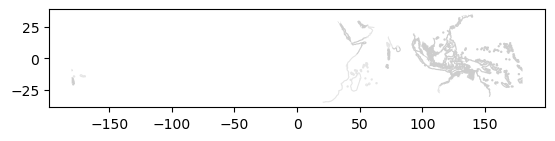

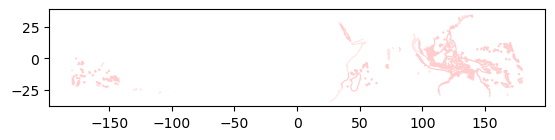

In [17]:
# plot the shapefile geometries on a worldmap
gdf.iloc[:2].plot(alpha=0.1, color='black')
gdf.iloc[4:6].plot(alpha=0.1, color='red')

In [4]:
from shapely.geometry import MultiPolygon, Polygon, box

# Define the bounding box for the grid
minx, miny, maxx, maxy = gdf.total_bounds

# Define the grid size
grid_size = 1

# Generate grid cells
x_coords = list(range(int(minx), int(maxx + 1), int(grid_size)))
y_coords = list(range(int(miny), int(maxy + 1), int(grid_size)))

grid_cells = []
for x in x_coords:
    for y in y_coords:
        grid_cells.append(box(x, y, x + grid_size, y + grid_size))

# Create a GeoDataFrame for the grid
grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
grid.crs = gdf.crs


In [5]:
# Spatial join to count overlaps
join = gpd.sjoin(grid, gdf.iloc[0:10], how='left', predicate='intersects')

# # Count overlaps in each grid cell
# overlap_counts = join.groupby('index_left').size()
# grid['overlaps'] = overlap_counts.reindex(grid.index, fill_value=0)

KeyError: 'index_left'

<Axes: >

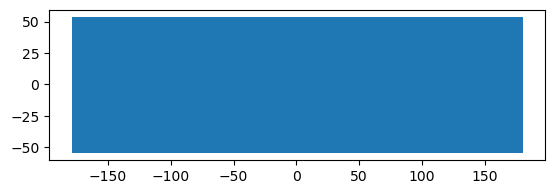

In [7]:
join.plot()